
Attempting to find clusters using [this approach](https://gis.stackexchange.com/a/11778/93394) (requires installing kmeans plugin to postgis).



While this notebook shows the general approach, it doesn't produce anything useful. To do that, two things need to happen:

* We'd have to warp the geometry so that the practices were spaced by population density, or similar.  At the moment you (unexpectedly) get clusters in London, Birmingham, etc.  (Could possibly use Cartogram deformations with [this lib](https://github.com/mthh/gpd_lite_toolbox))
* The second parameter you pass to the `kmeans` function is the number of clusters to generate. I'm not sure how you'd optimally find this number. 

Requires a ssh tunnel:

    ssh -L 3333:localhost:5432 hello@web2


In [5]:
import geopandas as gpd

ccgs = gpd.read_file('ccgs.json')  # from our API https://openprescribing.net/api/1.0/org_location/?org_type=ccg

In [6]:
import json
import psycopg2
with open('config.json') as f:
    conf = json.load(f)
conn_str = "host='localhost' dbname='prescribing' user='prescribing_readonly' password='{}' port='3333'".format(
    conf['passw'])
conn = psycopg2.connect(conn_str)
import pandas as pd
interestingpractices_sql = """
 WITH num AS (
      SELECT
        practice_id,
        SUM(num.quantity) AS q
      FROM
        frontend_prescription num
      WHERE
        processing_date = '2017-08-01'
        AND presentation_code LIKE '0212000AA%'
      GROUP BY
        practice_id),
      denom AS (
      SELECT
        practice_id,
        SUM(denom.quantity) AS q
      FROM
        frontend_prescription denom
      WHERE
        processing_date = '2017-08-01'
        AND presentation_code LIKE '0212000%'
      GROUP BY
        practice_id)
    SELECT
      num.q/denom.q AS ratio,
      num.practice_id,
      location,
      total_list_size
    FROM
      num
    INNER JOIN
      denom
    ON
      num.practice_id = denom.practice_id
    INNER JOIN
      frontend_practice
    ON
      frontend_practice.code = num.practice_id AND location is not null
    INNER JOIN
      frontend_practicestatistics stats
    ON 
      stats.practice_id = num.practice_id AND date = '2017-08-01'
"""
cluster_sql = """SELECT
  k2,
  COUNT(*) as count,
  ST_Centroid(ST_Collect(location)) AS location
FROM (
  SELECT
    kmeans(ARRAY[ST_X(location), ST_Y(location)],
      50) OVER ()  as k2,
    location
  FROM (%s) a
  WHERE
    ratio > 0.06 ) AS _
GROUP BY
  k2
ORDER BY
  count desc;""" % interestingpractices_sql
practices = gpd.GeoDataFrame.from_postgis(interestingpractices_sql, conn, geom_col='location')
clusters = gpd.GeoDataFrame.from_postgis(cluster_sql, conn, geom_col='location')



In [3]:
practices[practices.ratio > 0.06].head()

,ratio,practice_id,location,total_list_size
54,0.070631,A81066,POINT (-1.425131361611907 54.60463855115294),4354
116,0.072694,A82065,POINT (-2.915665478779596 54.18795643614756),2946
123,0.073744,A82077,POINT (-3.209520363448486 54.11271311954527),5242
209,0.077135,A83632,POINT (-1.679023098081619 54.85691457473216),2429
215,0.070763,A83644,POINT (-1.735490377987106 54.85676299260282),3504


In [4]:
clusters.head()

,k2,count,location
0,29,137,POINT (-0.1701286927327938 51.4885920497011)
1,49,64,POINT (0.402167039316988 51.22367538077461)
2,28,41,POINT (-2.215182136711942 53.49306319177985)
3,21,31,POINT (-0.7945838339097182 51.1488940524294)
4,30,30,POINT (-1.63612276310809 53.7103052625981)


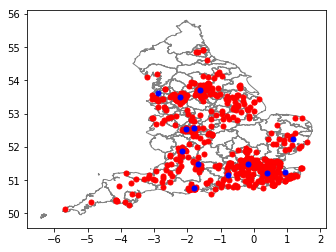

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.set_aspect('equal')

ccgs.plot(ax=ax, color='white', edgecolor='gray')
practices[practices.ratio > 0.06].plot(ax=ax, marker='o', color='red', markersize=5)
clusters[clusters['count'] > 10].plot(ax=ax, marker='o', color='blue', markersize=5)
plt.show()
